# Exploring WT expression threshold cutoff for nipBL dataset

***Purpose:*** To get more granularity on patterns of expression by referencing against wild-type expression. 

Aiming to answer questions such as: 
* does adding a threshold cut-off for WT expression make the observed patterns more apparent? 
* Do down-regulated genes seem more similar to non-significant genes that have high levels of expression?

Plots:
* Histogram of average counts, using different tables
* Using threshold cut-off to see distribution of [num enhancers/TAD] vs [num. genes/TAD]

In [1]:
import sys
 
# setting path
sys.path.append('../../transcription_data_analysis')

import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [2]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [55]:
proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"
# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv'
feature_counts = '20220816_featureCounts.csv'
vst_normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv'
WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

# import results table
day1_res_df = pd.read_csv(proj+day1_sigRes)

# add feature counts information to label genes not in the significant results table
feat_counts_df = pd.read_csv(proj+feature_counts)
day1_res_df = day1_res_df.merge(feat_counts_df['Geneid'], how='outer')

In [56]:
# import table of raw feature counts and calculate average
feat_counts_df = pd.read_csv(proj+feature_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
feat_counts_df['avg'] = feat_counts_df[WT_samples].mean(axis='columns')

# import table of normalized feature counts and calculate average
vst_counts_df = pd.read_csv(proj+vst_normalized_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
vst_counts_df['avg'] = vst_counts_df[WT_samples].mean(axis='columns')

feat_counts_df = feat_counts_df.merge(vst_counts_df, on='Geneid', how='left', suffixes=('_counts', '_vst_counts'))
feat_counts_df['avg_vst_counts'].fillna(feat_counts_df['avg_counts'], inplace=True)

# add average normalized counts value to results df
day1_res_df = day1_res_df.merge(feat_counts_df[['Geneid', 'avg_vst_counts', 'avg_counts']], on='Geneid', how='outer')

In [57]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
ts_intervals = flt.get_tss_gene_intervals(tss_df)

# labelling our dataset
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))
# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

# Remove any genes mapped to chrX before proceeding --> save these for later analysis
day1_res_df = day1_res_df[~day1_res_df.chrom.isin(['chrX'])]
day1_res_df = bf.sanitize_bedframe(day1_res_df)

# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


Checking for 'lost' significant genes: 
lost:  55


In [58]:
day1_res_df

,Geneid,SYMBOL,log2FoldChange,padj,baseMean,avg_vst_counts,avg_counts,gene_id,chrom,start,end,strand,DE_status
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735,6.255218,11.166667,ENSMUSG00000025128.7,chr3,18054173,18054173,+,down
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503,6.711927,28.333333,ENSMUSG00000051314.11,chr7,30823776,30823776,-,down
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936,8.010170,150.666667,ENSMUSG00000057182.15,chr2,65567493,65567493,-,down
3,ENSMUSG00000047495.15,Dlgap2,-3.530066,4.213601e-03,9.073752,6.361043,13.166667,ENSMUSG00000047495.15,chr8,14095864,14095864,+,down
4,ENSMUSG00000034310.8,Tmem132d,-3.518345,3.690000e-10,63.300332,7.357740,67.833333,ENSMUSG00000034310.8,chr5,128433078,128433078,-,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51160,ENSMUSG00000117740.1,NaN,NaN,NaN,NaN,5.673969,0.166667,ENSMUSG00000117740.1,chr19,61232927,61232927,-,nonsig
51161,ENSMUSG00000117782.1,NaN,NaN,NaN,NaN,5.658409,0.166667,ENSMUSG00000117782.1,chr19,61255966,61255966,+,nonsig
51162,ENSMUSG00000117951.1,NaN,NaN,NaN,NaN,5.976309,2.666667,ENSMUSG00000117951.1,chr19,61257790,61257790,-,nonsig
51163,ENSMUSG00000095993.1,NaN,NaN,NaN,NaN,6.379612,15.000000,ENSMUSG00000095993.1,chr19,61297070,61297070,-,nonsig


## Load data and project files

Using dataloader function to add feature annotations to gene set: TSS locations
Merging average normalized feature counts and average vst-normalized feature counts into results table

In [59]:
import importlib
importlib.reload(flt)

<module 'filter_gene_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/filter_gene_functions.py'>

In [60]:
default_mm10_gtf = '/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf'
default_project = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"

day1_sig_results = default_project+'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

def load_tss_df(gtf=default_mm10_gtf,
                rna_tsv=day1_sig_results,
                chrom_keep='autosomes',
                counts_tables={'raw_counts_name' : default_project+'20220816_featureCounts.csv',
                                'vst_counts' : default_project+'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv',
                              },
                counts_usage={'raw_counts_name' : 'append_name',
                              'vst_counts' : 'wt_avg'
                             },
                cutoff=6,
                cutoff_col='vst_counts_avg',
                wt_samples=['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']
               ):
    """
    Processes rna_tsv and returns a dataframe. Performs data manipulations 
    to annotate gene names and join additional features from experiment files.
    
    gtf: string for filename of .gtf file for this genome.
    rna_tsv: string filename of RNA seq results
    chrom_keep: ['autosomes', 'chromosomes'] defines which genes to keep based
        on chromosome mapping.
    counts_tables: {string name : string for filename} of additional rna-seq counts data tables
    counts_usage: {string name : string usage_setting} describing what data manipulations to apply
                   'append_name' gene_id from raw counts to re-index rna_tsv with full dataset
                   'wt_avg' takes average of wt samples and appends to rna_tsv
    cutoff: int cutoff value for filtering rows that fall below threshold
    cutoff_col: column in rna_tsv to compare to cutoff
    wt_samples: [list of sample names] that designate columns in counts_tables 
                only relevant if using 'wt_avg'
    function: _____ DE_status
    ------
    Returns

    rna_tsv
    """
    
    rna_df = pd.read_csv(day1_sig_results)
    
    for name, file in counts_tables.items():
        
        if counts_usage[name] == 'append_name':
            # add feature counts information to label genes not in the significant results table
            feat_df = pd.read_csv(file)
            rna_df = rna_df.merge(feat_counts_df['Geneid'], how='outer')
            
        elif counts_usage[name] == 'wt_avg':
            counts_df = pd.read_csv(file).rename(columns={'Unnamed: 0' : 'Geneid'}).astype({'Geneid': 'object'})
            counts_df['avg_'+name] = counts_df[wt_samples].mean(axis='columns')
            rna_df = rna_df.merge(counts_df[['Geneid', 'avg_'+name]], on='Geneid', how='outer')
            rna_df['avg_'+name].fillna(0, inplace=True)
            
    
    gtf_df = read_gtf(gtf)
    tss_intervals = flt.get_tss_gene_intervals(gtf_df)
    tss_intervals['tss'] = tss_intervals['start'].copy()
    
    tss_df = tss_intervals.merge(rna_df.copy(),  how='left',
                left_on='gene_id', right_on='Geneid')
    
    if cutoff is not None:
        cut = (tss_df[cutoff_col] > cutoff)
        tss_df = tss_df[cut]
    
    return tss_df

In [61]:
# Getting average counts for all three counts datasets
day1_res_df = load_tss_df(
                counts_tables={'raw_counts_name' : default_project+'20220816_featureCounts.csv',
                               'counts' : default_project+'20220816_featureCounts.csv',
                                'norm_counts' : default_project+'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv',
                                'vst_counts' : default_project+'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv',
                              },
                counts_usage={'raw_counts_name' : 'append_name',
                              'counts' : 'wt_avg',
                              'norm_counts' : 'wt_avg',
                              'vst_counts' : 'wt_avg'
                             },
                cutoff=None)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [62]:
day1_res_df

,gene_id,chrom,start,end,strand,tss,Geneid,SYMBOL,log2FoldChange,padj,baseMean,avg_counts,avg_norm_counts,avg_vst_counts
0,ENSMUSG00000102693.1,chr1,3073252,3073252,+,3073252,ENSMUSG00000102693.1,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000
1,ENSMUSG00000064842.1,chr1,3102015,3102015,+,3102015,ENSMUSG00000064842.1,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000
2,ENSMUSG00000051951.5,chr1,3216345,3216345,-,3216345,ENSMUSG00000051951.5,NaN,NaN,NaN,NaN,0.166667,0.0,5.666359
3,ENSMUSG00000102851.1,chr1,3252756,3252756,+,3252756,ENSMUSG00000102851.1,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000
4,ENSMUSG00000103377.1,chr1,3368550,3368550,-,3368550,ENSMUSG00000103377.1,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51105,ENSMUSG00000117740.1,chr19,61232927,61232927,-,61232927,ENSMUSG00000117740.1,NaN,NaN,NaN,NaN,0.166667,0.0,5.673969
51106,ENSMUSG00000117782.1,chr19,61255966,61255966,+,61255966,ENSMUSG00000117782.1,NaN,NaN,NaN,NaN,0.166667,0.0,5.658409
51107,ENSMUSG00000117951.1,chr19,61257790,61257790,-,61257790,ENSMUSG00000117951.1,NaN,NaN,NaN,NaN,2.666667,0.0,5.976309
51108,ENSMUSG00000095993.1,chr19,61297070,61297070,-,61297070,ENSMUSG00000095993.1,NaN,NaN,NaN,NaN,15.000000,0.0,6.379612


# Distribution of WT expression levels

### Average counts -- default normalization

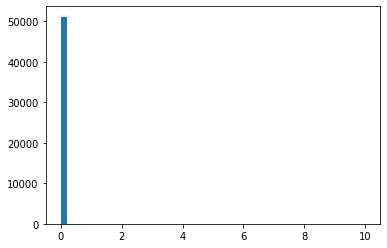

In [63]:
plt.hist(day1_res_df['avg_norm_counts'].values, range=(0, 10), bins=50)
plt.show()

### Average Counts -- not normalized

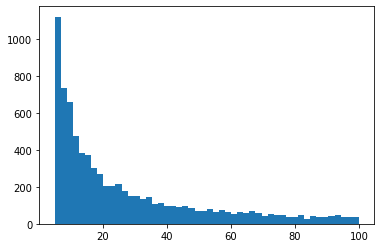

In [64]:
plt.hist(day1_res_df['avg_counts'].values, range=(5, 100), bins=50)
plt.show()

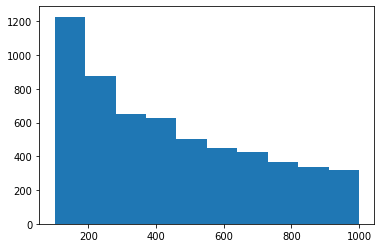

In [65]:
plt.hist(day1_res_df['avg_counts'].values, range=(100, 1000))
plt.show()

### average vst-normalized counts

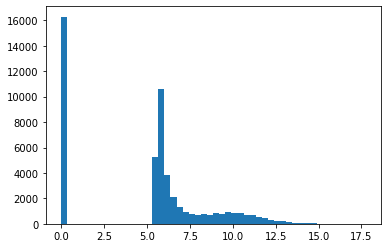

In [66]:
plt.hist(day1_res_df['avg_vst_counts'].values, bins=50)
plt.show()

### distribution of vst-normalized counts in nonsignificant genes

In [67]:
import importlib
importlib.reload(pfn)

<module 'plotting_histogram_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py'>

In [68]:
# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

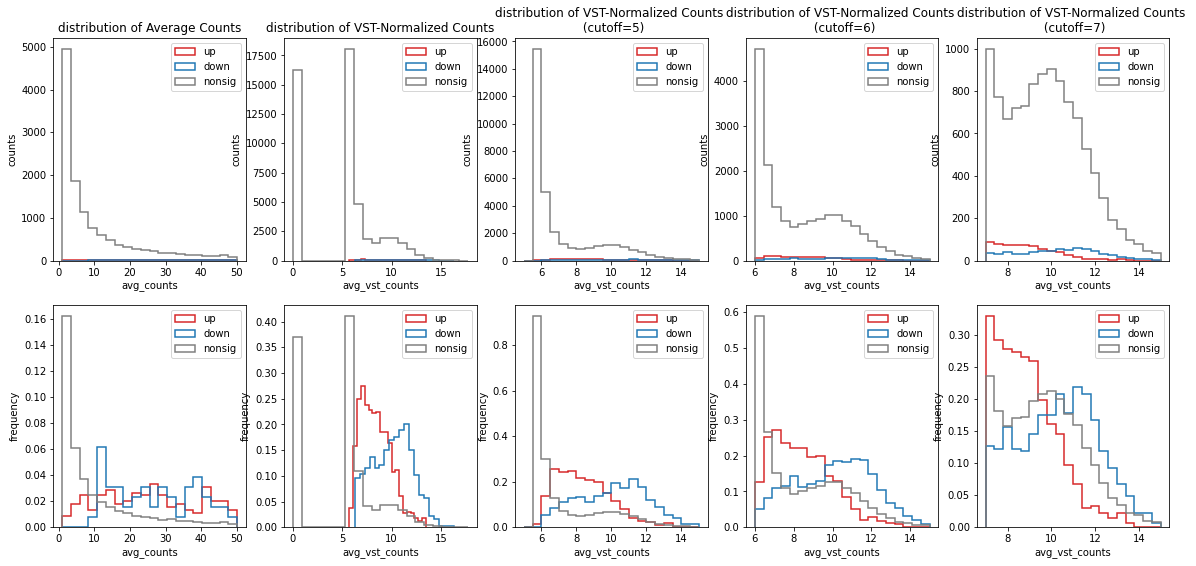

In [69]:
fig, axs = plt.subplots(2, 5, figsize=(20, 9))

plot_vars = [{'title': 'distribution of Average Counts',
              'col' : 'avg_counts',
              'range' : (1, 50),
              'ax1' : 0},
             {'title': 'distribution of VST-Normalized Counts',
              'col' : 'avg_vst_counts',
              'range' : None,
              'ax1' : 1},
             {'title': 'distribution of VST-Normalized Counts \n (cutoff=5)',
              'col' : 'avg_vst_counts',
              'range' : (5, 15),
              'ax1' : 2},
             {'title': 'distribution of VST-Normalized Counts \n (cutoff=6)',
              'col' : 'avg_vst_counts',
              'range' : (6, 15),
              'ax1' : 3},
             {'title': 'distribution of VST-Normalized Counts \n (cutoff=7)',
              'col' : 'avg_vst_counts',
              'range' : (7, 15),
              'ax1' : 4}]

for params in plot_vars:
    pfn.plot_categorized_histogram(day1_res_df, 
                            params['col'],
                            bins=20,
                            plot_title=params['title'],
                            val_range=params['range'],
                            ax=axs[0, params['ax1']])
    pfn.plot_categorized_histogram(day1_res_df, 
                            params['col'],
                            density=True,
                            bins=20,
                            val_range=params['range'],
                            ax=axs[1, params['ax1']])

### Observations:

It looks like the vst-normalized counts may have already enforced a threshold cut-off when exporting the results table from DESeq2. 

Generally, will threshold this dataset at vst_counts=6.

# Plot number of enhancers and DE genes within each TAD

How many dysregulated genes contain a distal enhancer in the same TAD?

* Investigating gene dysregulation relative to enhancers + HiC
* Comparing effect of applying threshold (cutoff = 6) before splitting datasets based on WT expression counts

In [72]:
import importlib
importlib.reload(flt)

<module 'filter_gene_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/filter_gene_functions.py'>

In [73]:
# load Hi-C data and features for boundaries
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

### label distance to closest enhancer for each gene

In [74]:
dataset_folder = '/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/Published_datasets/'

chen_s1 = 'Enhancers_Chen2012_S1_remapped_mm10.bed'
whythe_super = 'Super-enhancers_mESCs_(OSN-MED1)_Wythe-Cell-2023_mm10-lifetover.bed'
# whythe_reg = 'remapped_enhancers_Whyte_2013_mm9.bed.txt' <-- where is this?

enhancers = {'chen_s1' : dataset_folder+chen_s1,
             'wythe_super' : dataset_folder+whythe_super}

In [75]:
for label, file in enhancers.items():
    day1_res_df = flt.label_closest_enhancer(day1_res_df, file, label)

In [76]:
print('how many genes did not receive an enhancer label --> dropped')
print((day1_res_df['chen_s1_distance'].isna() |
       day1_res_df['wythe_super_distance'].isna()
      ).sum())
day1_res_df.dropna(subset=
                   ['chen_s1_distance', 
                    'wythe_super_distance'], 
                   inplace=True
                  )

how many genes did not receive an enhancer label --> dropped
0


In [77]:
# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

# label quantiles using full range of vst-normalized counts
quantiled_df = day1_res_df.copy()

quantiled_df = flt.label_quantiles(quantiled_df)
quantiled_df = flt.label_quantiles(quantiled_df, label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, label_subset='down')

category_colormap_big = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',

                         'nonsig_0.0-0.5' : '#d9d9d9',
                         'nonsig_0.5-0.75' : '#bdbdbd',
                         'nonsig_0.75-0.95' : '#969696',
                         'nonsig_0.95-1.0' : '#636363'
                        }

/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py:269: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
  warnings.warn(
/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py:335: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
  warnings.warn(
/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py:269: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
  warnings.warn(
/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/feature_histograms/../../transcription_data_analysis/plotting_histogram_functions.py:335: UserWarning: category down_0.0

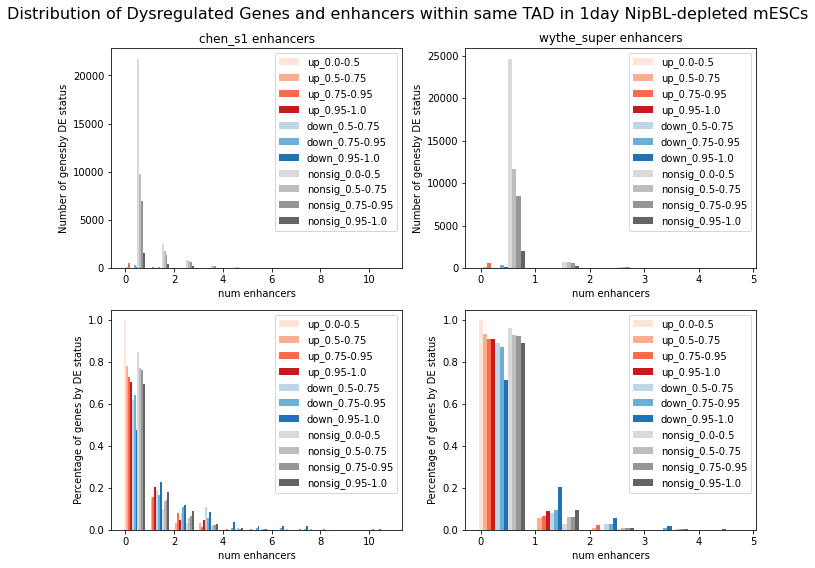

In [78]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    
    enhancer_df = flt.get_enhancer_bioframe(file)
    df['num_enhancers'] = bf.count_overlaps(df, enhancer_df)['count']
    
    pfn.group_features_by_region(df,
                                 quantiled_df,
                                 feature_category_colors=category_colormap_big,
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(df,
                                        quantiled_df,
                                        plot_title='',
                                        feature_category_colors=category_colormap_big,
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()

### Applying threshold = 6 before setting quantiles

In [79]:
quantiled_df['DE_status'].value_counts()

nonsig_0.0-0.5      25557
nonsig_0.5-0.75     12614
nonsig_0.75-0.95     9110
nonsig_0.95-1.0      2265
up_0.75-0.95          669
down_0.75-0.95        443
down_0.95-1.0         247
up_0.5-0.75           123
up_0.95-1.0            44
down_0.5-0.75          37
up_0.0-0.5              1
Name: DE_status, dtype: int64

In [80]:
# set counts threshold to 6.0
cutoff = 6.0
cut = (day1_res_df['avg_vst_counts'] > cutoff)
quantiled_df = day1_res_df[cut].copy()

quantiled_df = flt.label_quantiles(quantiled_df)
quantiled_df = flt.label_quantiles(quantiled_df, label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, label_subset='down')

In [81]:
quantiled_df['DE_status'].value_counts()

nonsig_0.0-0.5      9180
nonsig_0.5-0.75     4281
nonsig_0.75-0.95    3476
nonsig_0.95-1.0      854
up_0.0-0.5           363
up_0.5-0.75          342
down_0.75-0.95       283
down_0.5-0.75        214
down_0.0-0.5         132
up_0.75-0.95         110
down_0.95-1.0         98
up_0.95-1.0           16
Name: DE_status, dtype: int64

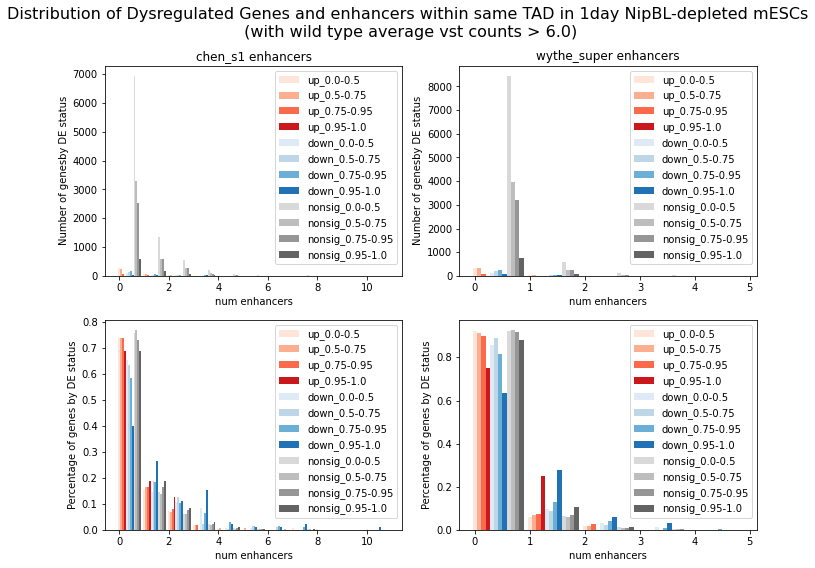

In [82]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'
             '\n (with wild type average vst counts > 6.0)'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    
    enhancer_df = flt.get_enhancer_bioframe(file)
    df['num_enhancers'] = bf.count_overlaps(df, enhancer_df)['count']
    
    pfn.group_features_by_region(df,
                                 quantiled_df,
                                 feature_category_colors=category_colormap_big,
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(df,
                                        quantiled_df,
                                        plot_title='',
                                        feature_category_colors=category_colormap_big,
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()

# Observations

* 

In [29]:
# Get the cutoffs
print(nonsig_quant_df[nonsig_quant_df['DE_status'] == 'nonsig_0.0-0.5']['avg_vst_counts'].max())
print(nonsig_quant_df[nonsig_quant_df['DE_status'] == 'nonsig_0.5-0.75']['avg_vst_counts'].max())

5.745031925200898
6.787650522478754


In [30]:
print(nonsig_quant_df[nonsig_quant_df['DE_status'] == 'down_0.0-0.5']['avg_vst_counts'].max())

nan


In [31]:
# ignoring user warning because adding threshold removes many of categories --> they are not plotted
warnings.simplefilter(action='ignore', category=UserWarning)